In [ ]:
%run init_notebook.py

import os
import torch
import torch.optim as optim
import torchaudio.transforms as T
import time
import torchaudio
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import Audio, display

from src.dataset import NSynth   
from src.models import VAE
from src.utils.models import adjust_shape
from src.utils.logger import save_training_results
from src.utils.models import compute_magnitude_and_phase

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r"C:\Users\Articuno\Desktop\TFG-info\data\models\vae.pth"

# STFT transform
sample_rate = 16000
n_fft = 1500
hop_length = 250
win_length = n_fft  # Same as n_fft

# Apply the correct transform for magnitude and phase (onesided=False to handle complex spectrogram)
stft_transform = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=None,  # Keep as complex spectrogram (magnitude and phase)
    onesided=False,  # Make sure we keep the full spectrum (complex-valued)
    center=False
).to(device)

# Define the inverse STFT function (onesided=False)
istft_transform = torchaudio.transforms.InverseSpectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    onesided=False  # Make sure we reconstruct using the full complex spectrogram
).to(device)

# Datasets and DataLoaders, training parameters.
train_dataset = NSynth(partition='training')
valid_dataset = NSynth(partition='validation')
test_dataset  = NSynth(partition='testing')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

input_height = 1500
input_width  = 251
input_size = (input_height, input_width)
latent_dim   = 200
channels = [2, 16, 32, 64]
learning_rate = 1e-4

model = VAE(input_size=input_size, latent_dim=latent_dim, channels=channels).to(device)
if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model loaded successfully.")
    except PermissionError as e:
        print(f"PermissionError: {e}. Unable to load the model.")
else:
    print("No saved model found, starting training from scratch.")

    # Model, Optimizer, and Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping params
    patience_es = 3
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Learning rate scheduler to reduce learning rate based on validation loss
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training
    num_epochs = 20
    total_epoch_time = 0.0
    warmup = 5  # for KL annealing
    training_losses, validation_losses = [], []
    recon_losses, kl_losses = [], []

    print(f"Starting training on {device}...")
    for epoch in range(num_epochs):
        model.train()
        running_train_loss  = 0.0
        running_train_recon = 0.0   
        running_train_kl    = 0.0
        beta = min(1.0, float(epoch + 1) / warmup)
        start = time.time()
        
        for waveform, _, _, _ in train_loader:
            waveform = waveform.to(device)
            stft_spec = stft_transform(waveform)
            mag, phase = compute_magnitude_and_phase(stft_spec)
            input_data = torch.cat([mag, phase], dim=1).to(device)
            
            optimizer.zero_grad()
            recon_term, kld = model(input_data)
            
            loss = model.loss_function(recon_term, kld, beta)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * waveform.size(0)

            # Save these for plotting
            recon_term = - recon_term.sum().item()      
            kl_term    = kld.sum().item()              
            running_train_recon += recon_term
            running_train_kl    += kl_term
        
        N = len(train_loader.dataset)
        avg_recon = running_train_recon / N
        avg_kl    = running_train_kl    / N

        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        avg_train_loss = running_train_loss / N
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for waveform, _, _, _ in valid_loader:
                waveform = waveform.to(device)
                stft_spec = stft_transform(waveform)
                mag, phase = compute_magnitude_and_phase(stft_spec)
                input_data = torch.cat([mag, phase], dim=1).to(device)
                
                recon_term, kld = model(input_data)
                loss = model.loss_function(recon_term, kld, beta)
                running_val_loss += loss.item() * waveform.size(0)
        
        avg_val_loss = running_val_loss / len(valid_loader.dataset)
        
        # LR scheduler step
        scheduler.step(avg_val_loss)

        training_losses.append(avg_train_loss)
        validation_losses.append(avg_val_loss)
        
        epoch_time = time.time() - start
        total_epoch_time += epoch_time

        print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.3f}, "
            f"valid_loss={avg_val_loss:.3f}, β={beta:.2f}, time={epoch_time:.1f}s")
        
        # Early stopping check (outside the warmup period)
        if epoch >= warmup:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), model_path)
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience_es:
                    print(f"Stopping early at epoch {epoch+1}")
                    break

    print("Training complete.")
    save_training_results({
        "train_losses": training_losses,
        "valid_losses": validation_losses,
        "recon_losses": recon_losses,
        "KL_losses": kl_losses,
        "num_epochs": len(training_losses),
        "avg_epoch_time": total_epoch_time / (epoch + 1),
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "sample_rate": sample_rate,
        "n_fft": n_fft,
        "hop_length": hop_length,
        "input_height": input_height,
        "input_width": input_width,
        "latent_dim": latent_dim,
        "patience": patience_es,
        "warmup": warmup,
    }, "vae.json")

    import matplotlib.pyplot as plt
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_losses, label='Training Loss', marker='o')
    plt.plot(epochs, validation_losses, label='Validation Loss', marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    epochs = range(1, len(recon_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, recon_losses, label='Reconstruction Loss (−E[log p(x|z)])', marker='o')
    plt.plot(epochs, kl_losses,    label='KL Divergence', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train: Recon vs KL Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Model:
 VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=385024, out_features=200, bias=True)
    (fc2): Linear(in_features=385024, out_features=200, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=200, out_features=385024, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 188, 32))
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): C

## Sampling from the VAE: Audio Generation

We sample from the **latent space** and decode the samples to reconstruct audio signals.

### Steps:

1. **Set model to evaluation mode**:
   Ensures dropout and batch norm (if any) behave deterministically.

2. **Sample latent vectors**:
   $$ Z \sim \mathcal{N}(0, I) $$
   We draw `num_samples` latent vectors from a standard Gaussian.

3. **Decode latent vectors**:
   The decoder produces a tensor of shape:
   $$
   \text{decoded} \in \mathbb{R}^{B \times 2 \times H \times W}
   $$
   where:
   - Channel 0: **magnitude**
   - Channel 1: **phase**

4. **Reconstruct complex STFT**:
   $$
   \hat{X} = \text{magnitude} \cdot e^{i \cdot \text{phase}}
   $$

5. **Apply inverse STFT** to obtain the waveform in the time domain:
   $$
   \hat{x}(t) = \text{ISTFT}(\hat{X})
   $$

6. **Listen to generated audio samples**:
   Each waveform is rendered using `IPython.display.Audio`.

In [ ]:
model.eval()

num_samples = 10
    
# Sample latents
Z = torch.randn(num_samples, latent_dim, device=device)

with torch.no_grad():
    # Decode latent vectors
    decoded = model.decoder(Z)  # (B, 2, H', W')
    decoded = adjust_shape(decoded, (input_height, input_width)) # (B, 2, H, W)

    # Separate magnitude and phase
    mag   = decoded[:, 0, :, :]         # (B, H, W)
    phase = decoded[:, 1, :, :]         # (B, H, W)

    # Reconstruct complex STFT
    complex_stft = mag * torch.exp(1j * phase)  # (B, H, W)

    # Inverse STFT to waveform
    reconstructed = istft_transform(complex_stft)  # (B, T)

# Play audios
for i in range(num_samples):
    print(f"\n=== Generated Sample {i+1} ===")
    waveform = reconstructed[i].squeeze().cpu().numpy()
    display(Audio(waveform, rate=sample_rate))


=== Generated Sample 1 ===



=== Generated Sample 2 ===



=== Generated Sample 3 ===



=== Generated Sample 4 ===



=== Generated Sample 5 ===



=== Generated Sample 6 ===



=== Generated Sample 7 ===



=== Generated Sample 8 ===



=== Generated Sample 9 ===



=== Generated Sample 10 ===


# Plotting the latent space

Does the VAE learn a latent representation that groups together similar-sounding instruments?

Principal Component Analysis (PCA) is a way to take high-dimensional data and find a new set of orthogonal axes (directions) that capture as much of its variability as possible, in descending order.

Model:
 VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=385024, out_features=200, bias=True)
    (fc2): Linear(in_features=385024, out_features=200, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=200, out_features=385024, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 188, 32))
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): C

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not array(['bass', 'organ', 'keyboard', 'mallet', 'bass', 'brass', 'guitar',
       'bass', 'keyboard', 'guitar', 'keyboard', 'guitar', 'string',
       'keyboard', 'brass', 'bass', 'string', 'keyboard', 'mallet',
       'bass', 'guitar', 'bass', 'keyboard', 'keyboard', 'mallet',
       'organ', 'organ', 'guitar', 'guitar', 'guitar', 'guitar',
       'keyboard', 'keyboard', 'keyboard', 'organ', 'guitar', 'reed',
       'string', 'bass', 'keyboard', 'keyboard', 'bass', 'guitar',
       'organ', 'reed', 'guitar', 'organ', 'organ', 'organ', 'organ',
       'keyboard', 'string', 'keyboard', 'keyboard', 'bass', 'string',
       'guitar', 'organ', 'keyboard', 'keyboard', 'guitar', 'brass',
       'organ', 'keyboard', 'guitar', 'string', 'bass', 'flute', 'mallet',
       'bass', 'bass', 'keyboard', 'keyboard', 'reed', 'keyboard',
       'keyboard', 'bass', 'brass', 'bass', 'vocal', 'reed', 'brass',
       'guitar', 'guitar', 'keyboard', 'organ', 'organ', 'vocal',
       'keyboard', 'guitar', 'guitar', 'string', 'guitar', 'flute',
       'organ', 'bass', 'keyboard', 'string', 'keyboard', 'guitar',
       'bass', 'bass', 'reed', 'bass', 'keyboard', 'flute', 'string',
       'bass', 'bass', 'guitar', 'keyboard', 'keyboard', 'mallet', 'reed',
       'bass', 'organ', 'mallet', 'brass', 'bass', 'string', 'guitar',
       'flute', 'reed', 'guitar', 'bass', 'reed', 'mallet', 'organ',
       'bass', 'flute', 'brass', 'brass', 'mallet', 'brass', 'reed',
       'bass', 'brass', 'keyboard', 'organ', 'vocal', 'organ', 'guitar',
       'mallet', 'flute', 'organ', 'vocal', 'keyboard', 'flute', 'string',
       'string', 'string', 'organ', 'string', 'keyboard', 'organ',
       'keyboard', 'organ', 'brass', 'keyboard', 'bass', 'bass',
       'keyboard', 'organ', 'bass', 'mallet', 'guitar', 'keyboard',
       'flute', 'bass', 'flute', 'string', 'mallet', 'organ', 'bass',
       'mallet', 'brass', 'keyboard', 'bass', 'keyboard', 'guitar',
       'bass', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'bass',
       'reed', 'mallet', 'guitar', 'mallet', 'string', 'keyboard',
       'brass', 'bass', 'string', 'bass', 'organ', 'bass', 'bass',
       'organ', 'flute', 'organ', 'brass', 'bass', 'keyboard', 'bass',
       'vocal', 'brass', 'string', 'bass', 'mallet', 'organ', 'guitar',
       'string', 'keyboard', 'bass', 'bass', 'keyboard', 'guitar',
       'mallet', 'bass', 'organ', 'organ', 'keyboard', 'string', 'guitar',
       'keyboard', 'guitar', 'flute', 'guitar', 'organ', 'keyboard',
       'string', 'keyboard', 'string', 'mallet', 'guitar', 'guitar',
       'organ', 'bass', 'keyboard', 'bass', 'keyboard', 'guitar',
       'guitar', 'string', 'bass', 'mallet', 'guitar', 'vocal',
       'keyboard', 'bass', 'organ', 'keyboard', 'string', 'bass', 'bass',
       'guitar', 'string', 'bass', 'string', 'string', 'reed', 'brass',
       'string', 'brass', 'keyboard', 'organ', 'string', 'bass', 'flute',
       'guitar', 'organ', 'keyboard', 'bass', 'keyboard', 'mallet',
       'organ', 'string', 'flute', 'guitar', 'guitar', 'guitar',
       'keyboard', 'reed', 'keyboard', 'bass', 'mallet', 'bass', 'organ',
       'bass', 'string', 'mallet', 'reed', 'brass', 'brass', 'bass',
       'organ', 'bass', 'guitar', 'brass', 'brass', 'bass', 'bass',
       'bass', 'keyboard', 'vocal', 'vocal', 'brass', 'reed', 'organ',
       'guitar', 'vocal', 'guitar', 'keyboard', 'mallet', 'organ', 'bass',
       'keyboard', 'keyboard', 'reed', 'string', 'bass', 'brass',
       'keyboard', 'guitar', 'flute', 'bass', 'guitar', 'guitar', 'bass',
       'bass', 'mallet', 'brass', 'guitar', 'string', 'guitar', 'brass',
       'bass', 'bass', 'keyboard', 'vocal', 'keyboard', 'keyboard',
       'keyboard', 'bass', 'keyboard', 'mallet', 'guitar', 'organ',
       'guitar', 'bass', 'keyboard', 'keyboard', 'mallet', 'keyboard',
       'guitar', 'keyboard', 'guitar', 'vocal', 'keyboard', 'keyboard',
       'bass', 'bass', 'bass', 'keyboard', 'guitar', 'brass', 'organ',
       'bass', 'vocal', 'organ', 'keyboard', 'keyboard', 'keyboard',
       'string', 'keyboard', 'string', 'keyboard', 'guitar', 'guitar',
       'keyboard', 'keyboard', 'organ', 'guitar', 'guitar', 'reed',
       'mallet', 'keyboard', 'organ', 'string', 'guitar', 'guitar',
       'bass', 'bass', 'guitar', 'brass', 'brass', 'bass', 'keyboard',
       'reed', 'keyboard', 'flute', 'bass', 'keyboard', 'bass', 'reed',
       'organ', 'guitar', 'reed', 'bass', 'vocal', 'bass', 'bass',
       'guitar', 'keyboard', 'brass', 'string', 'flute', 'keyboard',
       'bass', 'bass', 'bass', 'keyboard', 'bass', 'reed', 'mallet',
       'bass', 'keyboard', 'organ', 'flute', 'vocal', 'vocal', 'guitar',
       'bass', 'guitar', 'guitar', 'bass', 'bass', 'bass', 'guitar',
       'mallet', 'guitar', 'organ', 'guitar', 'guitar', 'bass', 'organ',
       'bass', 'guitar', 'brass', 'brass', 'keyboard', 'string',
       'keyboard', 'string', 'string', 'organ', 'keyboard', 'keyboard',
       'organ', 'guitar', 'guitar', 'mallet', 'bass', 'bass', 'mallet',
       'mallet', 'guitar', 'keyboard', 'flute', 'keyboard', 'bass',
       'keyboard', 'mallet', 'organ', 'bass', 'bass', 'keyboard', 'bass',
       'bass', 'bass', 'vocal', 'reed', 'bass', 'keyboard', 'keyboard',
       'bass', 'bass', 'keyboard', 'keyboard', 'keyboard', 'bass',
       'brass', 'bass', 'guitar', 'string', 'guitar', 'bass', 'flute',
       'keyboard', 'keyboard', 'organ', 'keyboard', 'mallet', 'bass',
       'bass', 'keyboard', 'reed', 'reed', 'organ', 'vocal', 'organ',
       'guitar', 'vocal', 'brass', 'keyboard', 'bass', 'vocal', 'brass',
       'bass', 'bass', 'reed', 'keyboard', 'bass', 'guitar', 'keyboard',
       'keyboard', 'keyboard', 'bass', 'bass', 'bass', 'organ', 'bass',
       'organ', 'bass', 'guitar', 'bass', 'guitar', 'bass', 'keyboard',
       'keyboard', 'string', 'bass', 'vocal', 'guitar', 'reed', 'guitar',
       'bass', 'keyboard', 'guitar', 'reed', 'string', 'keyboard',
       'keyboard', 'keyboard', 'mallet', 'bass', 'guitar', 'bass',
       'brass', 'brass', 'flute', 'organ', 'bass', 'brass', 'bass',
       'guitar', 'keyboard', 'vocal', 'organ', 'brass', 'bass', 'flute',
       'organ', 'keyboard', 'keyboard', 'reed', 'organ', 'brass', 'reed',
       'reed', 'keyboard', 'bass', 'reed', 'keyboard', 'keyboard',
       'keyboard', 'organ', 'bass', 'mallet', 'organ', 'vocal', 'organ',
       'keyboard', 'reed', 'brass', 'guitar', 'keyboard', 'keyboard',
       'guitar', 'keyboard', 'string', 'bass', 'flute', 'bass',
       'keyboard', 'guitar', 'guitar', 'keyboard', 'bass', 'string',
       'organ', 'string', 'bass', 'flute', 'guitar', 'bass', 'organ',
       'organ', 'vocal', 'organ', 'keyboard', 'bass', 'brass', 'keyboard',
       'keyboard', 'mallet', 'bass', 'organ', 'keyboard', 'guitar',
       'organ', 'guitar', 'string', 'organ', 'bass', 'keyboard', 'bass',
       'bass', 'brass', 'guitar', 'keyboard', 'bass', 'organ', 'guitar',
       'bass', 'keyboard', 'mallet', 'string', 'flute', 'reed', 'guitar',
       'bass', 'mallet', 'keyboard', 'string', 'string', 'keyboard',
       'guitar', 'guitar', 'organ', 'keyboard', 'bass', 'guitar',
       'keyboard', 'organ', 'vocal', 'reed', 'keyboard', 'flute',
       'keyboard', 'keyboard', 'flute', 'bass', 'organ', 'keyboard',
       'brass', 'guitar', 'reed', 'guitar', 'bass', 'string', 'organ',
       'keyboard', 'guitar', 'keyboard', 'bass', 'guitar', 'mallet',
       'bass', 'flute', 'keyboard', 'keyboard', 'vocal', 'string', 'bass',
       'reed', 'string', 'keyboard', 'string', 'bass', 'bass', 'brass',
       'keyboard', 'keyboard', 'organ', 'flute', 'bass', 'guitar',
       'keyboard', 'guitar', 'string', 'keyboard', 'keyboard', 'guitar',
       'reed', 'bass', 'bass', 'keyboard', 'keyboard', 'bass', 'string',
       'vocal', 'flute', 'reed', 'keyboard', 'bass', 'bass', 'string',
       'guitar', 'keyboard', 'flute', 'bass', 'guitar', 'flute', 'reed',
       'bass', 'flute', 'keyboard', 'guitar', 'bass', 'guitar', 'bass',
       'keyboard', 'organ', 'guitar', 'keyboard', 'guitar', 'organ',
       'string', 'organ', 'keyboard', 'brass', 'string', 'brass',
       'keyboard', 'bass', 'guitar', 'vocal', 'keyboard', 'keyboard',
       'keyboard', 'bass', 'reed', 'keyboard', 'bass', 'organ',
       'keyboard', 'organ', 'bass', 'keyboard', 'brass', 'guitar',
       'brass', 'guitar', 'guitar', 'flute', 'guitar', 'organ',
       'keyboard', 'keyboard', 'guitar', 'flute', 'reed', 'bass',
       'mallet', 'flute', 'reed', 'bass', 'vocal', 'string', 'bass',
       'string', 'brass', 'guitar', 'flute', 'organ', 'brass', 'mallet',
       'organ', 'reed', 'keyboard', 'string', 'brass', 'bass', 'bass',
       'guitar', 'bass', 'keyboard', 'guitar', 'vocal', 'keyboard',
       'string', 'reed', 'bass', 'keyboard', 'bass', 'bass', 'reed',
       'reed', 'reed', 'bass', 'bass', 'organ', 'keyboard', 'mallet',
       'bass', 'brass', 'bass', 'bass', 'bass', 'reed', 'string', 'flute',
       'bass', 'keyboard', 'flute', 'guitar', 'organ', 'keyboard',
       'string', 'string', 'guitar', 'keyboard', 'guitar', 'bass', 'reed',
       'keyboard', 'bass', 'bass', 'keyboard', 'mallet', 'mallet', 'bass',
       'keyboard', 'guitar', 'bass', 'reed', 'keyboard', 'keyboard',
       'guitar', 'keyboard', 'reed', 'guitar', 'flute', 'flute', 'brass',
       'string', 'guitar', 'organ', 'organ', 'keyboard', 'guitar',
       'organ', 'organ', 'keyboard', 'keyboard', 'bass', 'keyboard',
       'string', 'keyboard', 'guitar', 'guitar', 'brass', 'vocal',
       'mallet', 'bass', 'organ', 'organ', 'bass', 'bass', 'guitar',
       'organ', 'bass', 'flute', 'bass', 'guitar', 'bass', 'organ',
       'string', 'organ', 'string', 'bass', 'bass', 'reed', 'organ',
       'flute', 'string', 'bass', 'bass', 'keyboard', 'guitar', 'organ',
       'keyboard', 'reed', 'organ', 'organ', 'bass', 'flute', 'organ',
       'brass', 'mallet', 'mallet', 'bass', 'mallet', 'keyboard', 'bass',
       'guitar', 'keyboard', 'vocal', 'string', 'guitar', 'keyboard',
       'guitar', 'mallet', 'organ', 'flute', 'keyboard', 'vocal', 'bass',
       'keyboard', 'organ', 'string', 'guitar', 'bass', 'bass', 'brass',
       'organ', 'brass', 'vocal', 'flute', 'guitar', 'keyboard', 'bass',
       'bass', 'reed', 'keyboard', 'organ', 'brass', 'vocal', 'bass',
       'guitar', 'bass', 'keyboard', 'keyboard', 'mallet', 'reed',
       'keyboard', 'flute', 'bass', 'brass', 'vocal', 'brass', 'flute',
       'organ', 'bass', 'keyboard', 'keyboard', 'string', 'keyboard',
       'organ', 'bass', 'keyboard', 'string', 'bass', 'reed', 'string',
       'flute', 'mallet', 'bass', 'bass', 'organ', 'string', 'keyboard',
       'bass', 'guitar', 'brass', 'string'], dtype='<U8')

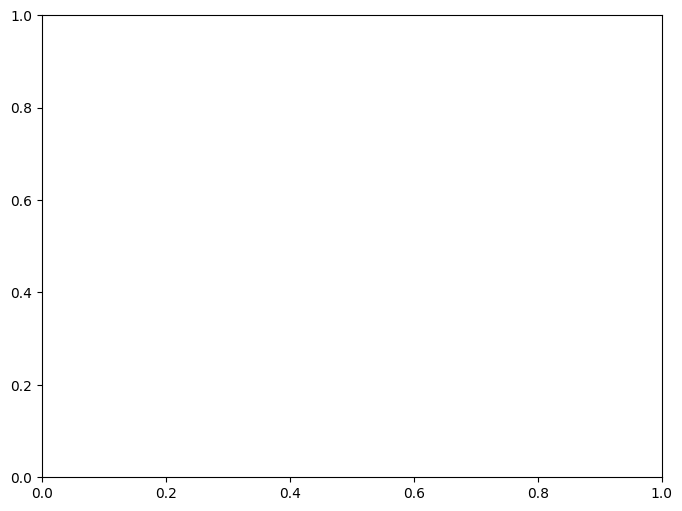

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src.dataset import NSynth
from src.models import VAE
from src.utils.models import compute_magnitude_and_phase, adjust_shape
from src.utils.dataset import INSTRUMENT_ID_2_STR
import torchaudio.transforms as T

model = VAE((input_height, input_width), latent_dim=latent_dim, channels=channels).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Dataset + loader
dataset = NSynth(partition='testing')
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many points to plot
N = 1000
mus    = []
labels = []

with torch.no_grad():
    for waveform, _, _, metadata in loader:
        B = waveform.size(0)
        waveform = waveform.to(device)  
        S = stft_transform(waveform)                    # [B,1,F,T]
        mag, ph = compute_magnitude_and_phase(S)        # each [B,1,F,T]
        x = torch.cat([mag, ph], dim=1)                 # [B,2,F,T]

        # encoder returns (feat, mu, logvar)
        _, mu, _ = model.encoder(x)
        mus.append(mu.cpu().numpy())

        # convert one‐hot instrument to string
        oh = metadata['one_hot_instrument']
        for v in oh:
            labels.append(INSTRUMENT_ID_2_STR[int(v.argmax())])

        if len(labels) >= N:
            break

mus    = np.vstack(mus)[:N]      # shape (N, latent_dim)
labels = np.array(labels[:N])    # shape (N,)

# Map each unique string label to an integer color code
unique_instr   = np.unique(labels)
instr2code     = {instr: i for i, instr in enumerate(unique_instr)}
color_codes    = np.array([instr2code[l] for l in labels])  # shape (N,)

# PCA down to 2D
pca = PCA(n_components=2)
z2  = pca.fit_transform(mus)  # shape (N,2)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    z2[:,0], z2[:,1],
    c=color_codes,
    cmap='tab10',
    s=10,
    alpha=0.7
)

# Build legend
handles, _ = scatter.legend_elements(num=len(unique_instr))
plt.legend(handles, unique_instr, title="Instrument", loc='best')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of VAE Latent Means by Instrument")
plt.tight_layout()
plt.show()